In [1]:
suppressMessages(library(umap))
suppressMessages(library(ggplot2))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggthemes))

In [2]:
# set file path to the concatenated aggregated feature selected profiles
path.data = file.path("./results/concat_data/batch_1_concat_agg_fs.csv")
if (!file.exists(path.data)){
    stop("Concatenated aggregated feature selected profiles not found. Please run the 'preprocessing-data.ipynb' script first.")
}

# setting output path
path.output = file.path("./results/umap")
if (!dir.exists(path.output)){
    dir.create(path.output, recursive = TRUE)
}


In [3]:
# loading the data 
concat.agg_fs_df = read.csv(path.data)
head(concat.agg_fs_df)

,Metadata_plate_barcode,Metadata_plate_index,Metadata_control_type,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Pathway,⋯,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_01_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_02_256,Nuclei_Texture_InverseDifferenceMoment_Hoechst_3_03_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_00_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumEntropy_PM_3_01_256
,<chr>,<int>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,localhost240927060001,1,positive,B,2,7,healthy,,DMSO-positive,,⋯,0.3402256,-0.3977194,-0.5544103,-0.5970321,-0.5998412,-0.4522333,-0.5126901,-0.4790599,-0.4874560,0.3777112
2,localhost240927060001,1,trt,B,3,19,failing,dilated_cardiomyopathy,UCD-0159256,Apoptosis,⋯,0.4267324,0.1924430,0.2015907,0.1935991,0.2079430,-0.5910820,-0.5959711,-0.4389208,-0.5724505,0.5092030
3,localhost240927060001,1,trt,B,4,19,failing,dilated_cardiomyopathy,UCD-0001766,Angiogenesis,⋯,0.9700897,-0.7807601,-0.8462625,-0.6546404,-0.6552967,-1.2822197,-1.3810076,-1.3441342,-1.2412133,1.4323676
4,localhost240927060001,1,positive,B,5,7,healthy,,DMSO-positive,,⋯,0.2186040,-0.1258398,-0.1072533,-0.2172325,-0.3029844,-0.2181221,-0.2854488,-0.1811892,-0.3076377,0.2273596
5,localhost240927060001,1,trt,B,6,19,failing,dilated_cardiomyopathy,UCD-0159262,Others,⋯,1.0391611,-1.0431304,-1.1731012,-1.0735004,-0.9949484,-1.6808244,-1.5534255,-1.7275510,-1.4432826,1.5518070
6,localhost240927060001,1,trt,B,7,19,failing,dilated_cardiomyopathy,UCD-0001915,Others,⋯,0.9578062,-0.6130803,-0.5006375,-0.5689286,-0.5950085,-0.4857848,-0.4584071,-0.4900697,-0.4551994,0.8125465


In [4]:
# setting metadata to keep
sel_metadata <- c("Metadata_plate_barcode", "Metadata_control_type", "Metadata_Pathway", "Metadata_treatment")

# separating metadata and morphology data
metadata_df <- concat.agg_fs_df[,sel_metadata]
morphology_df <- concat.agg_fs_df[,!grepl("^Metadata_", colnames(concat.agg_fs_df))]

# if Treatment is DMSO and Metadata_Pathway is empty, set Metadata_Pathway to DMSO
metadata_df$Metadata_Pathway[metadata_df$Metadata_treatment == "DMSO-positive" & metadata_df$Metadata_Pathway == ""] <- "DMSO"
metadata_df$Metadata_Pathway[metadata_df$Metadata_treatment == "DMSO-negative" & metadata_df$Metadata_Pathway == ""] <- "DMSO"

# if Treatment is not DMSO and Metadata_Pathway is empty, set Metadata_Pathway to unknown
metadata_df$Metadata_Pathway[metadata_df$Metadata_treatment != "DMSO" & metadata_df$Metadata_Pathway == ""] <- "Unknown"

## Generating UMAP components

UMAP components that only represent the control profiles (this has not treated profiles)

In [5]:
# setting seed
set.seed(0)

# generated a control_df where the Metadata_control_type is positive or negative.
# only select rows where the Metadata_control_type is positive or negative
control_df <- concat.agg_fs_df[concat.agg_fs_df$Metadata_control_type %in% 
							   c("positive", "negative"), ]
control_morphology_df <- control_df[,!grepl("^Metadata_", colnames(control_df))]
cntrls_umap_result <- umap(control_morphology_df, n_components = 2)
umap_control_df <- data.frame(
  Plate = control_df$Metadata_plate_barcode,
  Pathway = control_df$Metadata_Pathway,
  ControlType = control_df$Metadata_control_type,
  UMAP1 = cntrls_umap_result$layout[,1],
  UMAP2 = cntrls_umap_result$layout[,2]
)

UMAP components that represents controls and treated groups

In [6]:
# setting seed
set.seed(0)

# Extract only morphology data (exclude metadata)
morphology_features <- morphology_df  

# Ensure row names in metadata match morphology_features
rownames(metadata_df) <- rownames(morphology_features)

# Perform UMAP
umap_result <- umap(morphology_features, n_components = 2)

# Create a data frame with UMAP results and metadata
umap_df <- data.frame(
  Plate = metadata_df$Metadata_plate_barcode,
  Pathway = metadata_df$Metadata_Pathway,
  Treatment = metadata_df$Metadata_treatment,
  UMAP1 = umap_result$layout[,1],
  UMAP2 = umap_result$layout[,2]
)

## Creating a UMAP plot just for the DMSO 

[1] "UMAP of control profiles saved at ./results/umap/umap_control_profiles.png"


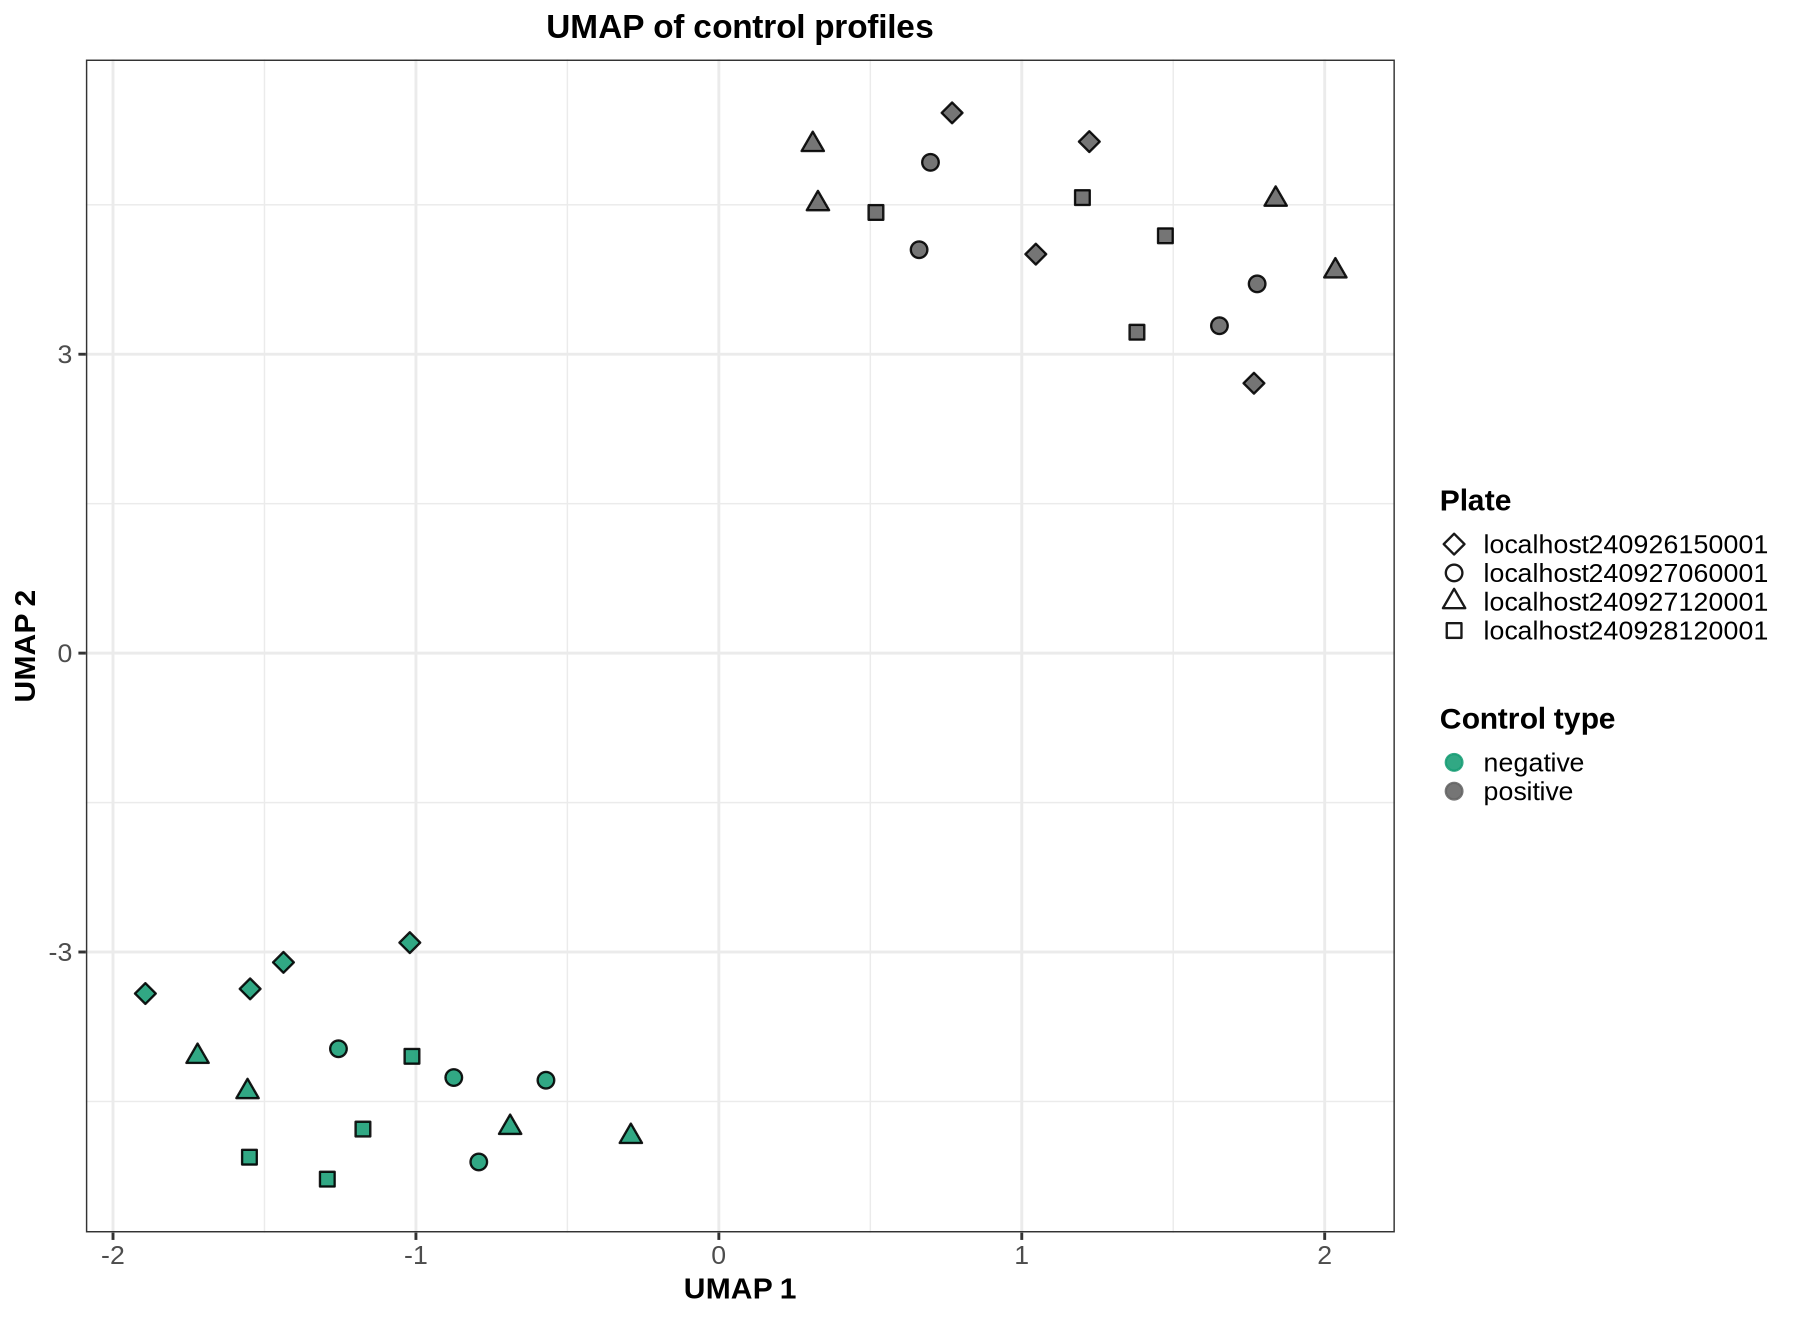

In [7]:
# make figure larger
options(repr.plot.width=15, repr.plot.height=11)

# Generate a color palette dynamically for ControlType (colorblind-friendly)
control_colors <- setNames(
  colorRampPalette(brewer.pal(8, "Dark2"))(length(unique(umap_control_df$ControlType))),
  unique(umap_control_df$ControlType)
)

# Define distinct filled shapes for Plate (21–25 allow fill)
plate_shapes <- c(21, 22, 23, 24, 25)  # These allow filling
names(plate_shapes) <- unique(umap_control_df$Plate)

# plotting the UMAP
ggplot(umap_control_df, aes(x = UMAP1, y = UMAP2, shape = Plate, fill = ControlType)) +
  geom_point(size = 4, stroke = 1, color = "black", alpha = 0.9) +  # Larger points with black border
  scale_shape_manual(values = plate_shapes) +  # Assign shapes to Plate
  scale_fill_manual(values = control_colors) +  # Fill shapes by ControlType
  theme_bw(base_size = 18) +  # Increase base font size
  labs(
    title = "UMAP of control profiles",
    x = "UMAP 1",
    y = "UMAP 2",
    fill = "Control type", 
    shape = "Plate"  
  ) +
  guides(fill = guide_legend(override.aes = list(color = control_colors))) +  # Add color to legend
  theme(
    legend.position = "right",  
    legend.text = element_text(size = 16), # Place legend on the right
    legend.title = element_text(size = 18, face = "bold"),  
    axis.text = element_text(size = 16),  
    axis.title = element_text(size = 18, face = "bold"),  
    plot.title = element_text(size = 20, face = "bold", hjust = 0.5) 
  )


# save figure into the output folder
path.figure <- file.path(path.output, "umap_control_profiles.png")
ggsave(path.figure, width = 15, height = 11, units = "in", dpi = 300)
print(paste("UMAP of control profiles saved at", path.figure))

## Making a UMAP plot of all morphology features and treated wells

Generating color palletes

In [8]:
# Generate a color palette dynamically for unique plates 
plate_colors <- setNames(
  colorRampPalette(brewer.pal(8, "Dark2"))(length(unique(umap_df$Plate))),  
  unique(umap_df$Plate)
)

# Generate a color palette dynamical for unique treatments (total of 51)
treatment_colors <- setNames(
  colorRampPalette(brewer.pal(8, "Dark2"))(length(unique(umap_df$Treatment))),
  unique(umap_df$Treatment)
)

[1] "UMAP of all plate profiles saved at ./results/umap/umap_all_plate_profiles.png"


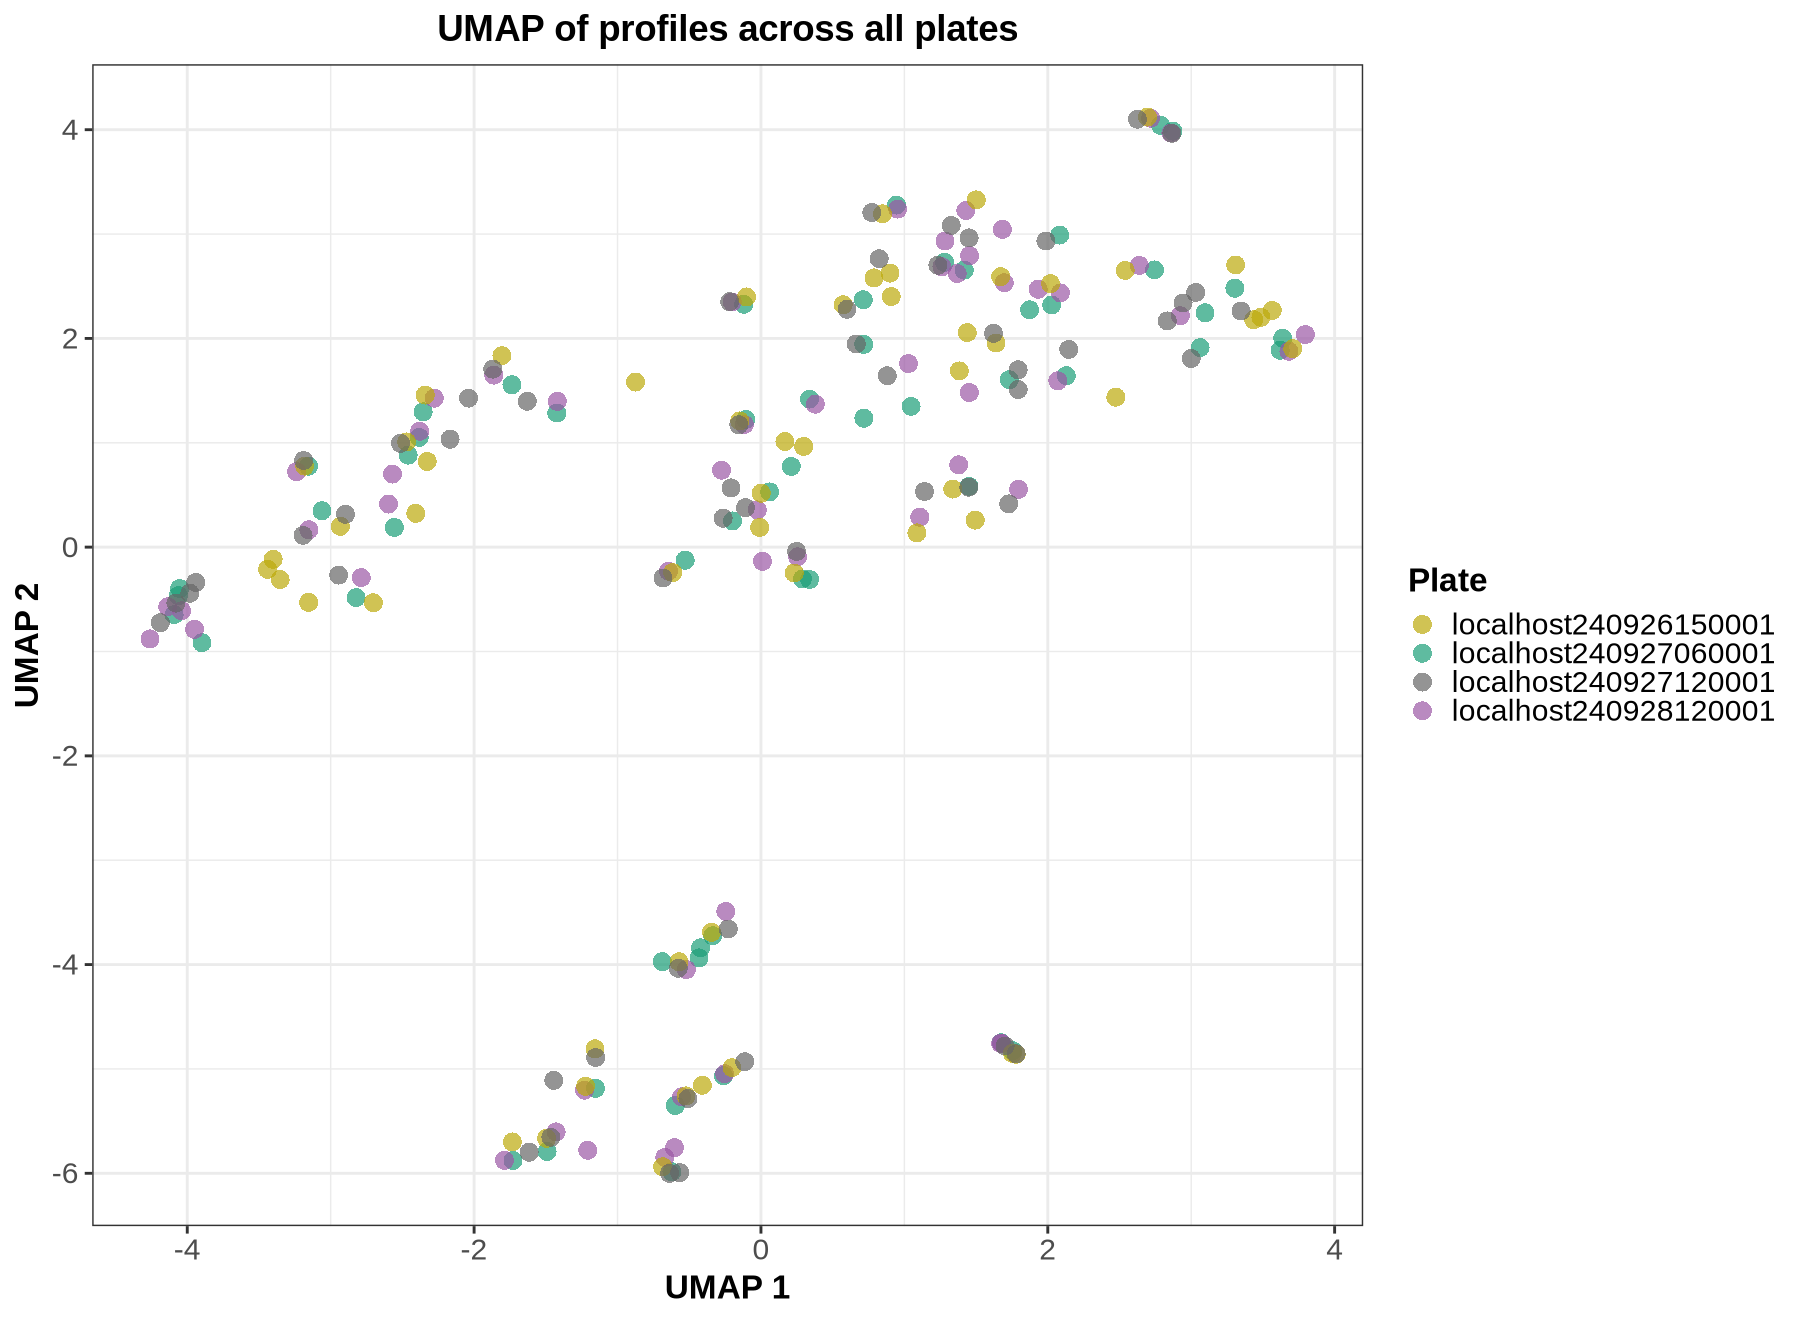

In [9]:
# set seed
set.seed(0)

# Plot UMAP with enhanced aesthetics for publication
ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Plate)) +
  geom_point(alpha = 0.7, size = 5, shape = 16) +  
  scale_color_manual(values = plate_colors) +  
  theme_bw(base_size = 18) +  
  labs(
    title = "UMAP of profiles across all plates",
    x = "UMAP 1",
    y = "UMAP 2",
    color = "Plate"  
  ) +
  theme(
    legend.position = "right",  
    legend.text = element_text(size = 18),  
    legend.title = element_text(size = 20, face = "bold"),  
    axis.text = element_text(size = 18),  
    axis.title = element_text(size = 20, face = "bold"),  
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5)  
  )

  # save figure into the output folder
path.figure <- file.path(path.output, "umap_all_plate_profiles.png")
ggsave(path.figure, width = 15, height = 11, units = "in", dpi = 300)
print(paste("UMAP of all plate profiles saved at", path.figure))

> This facet plot presents UMAP embeddings generated at the batch level, encompassing four plates, with data points colored according to their respective plates.

[1] "UMAP of pathway profiles saved at ./results/umap/umap_pathway_profiles.png"


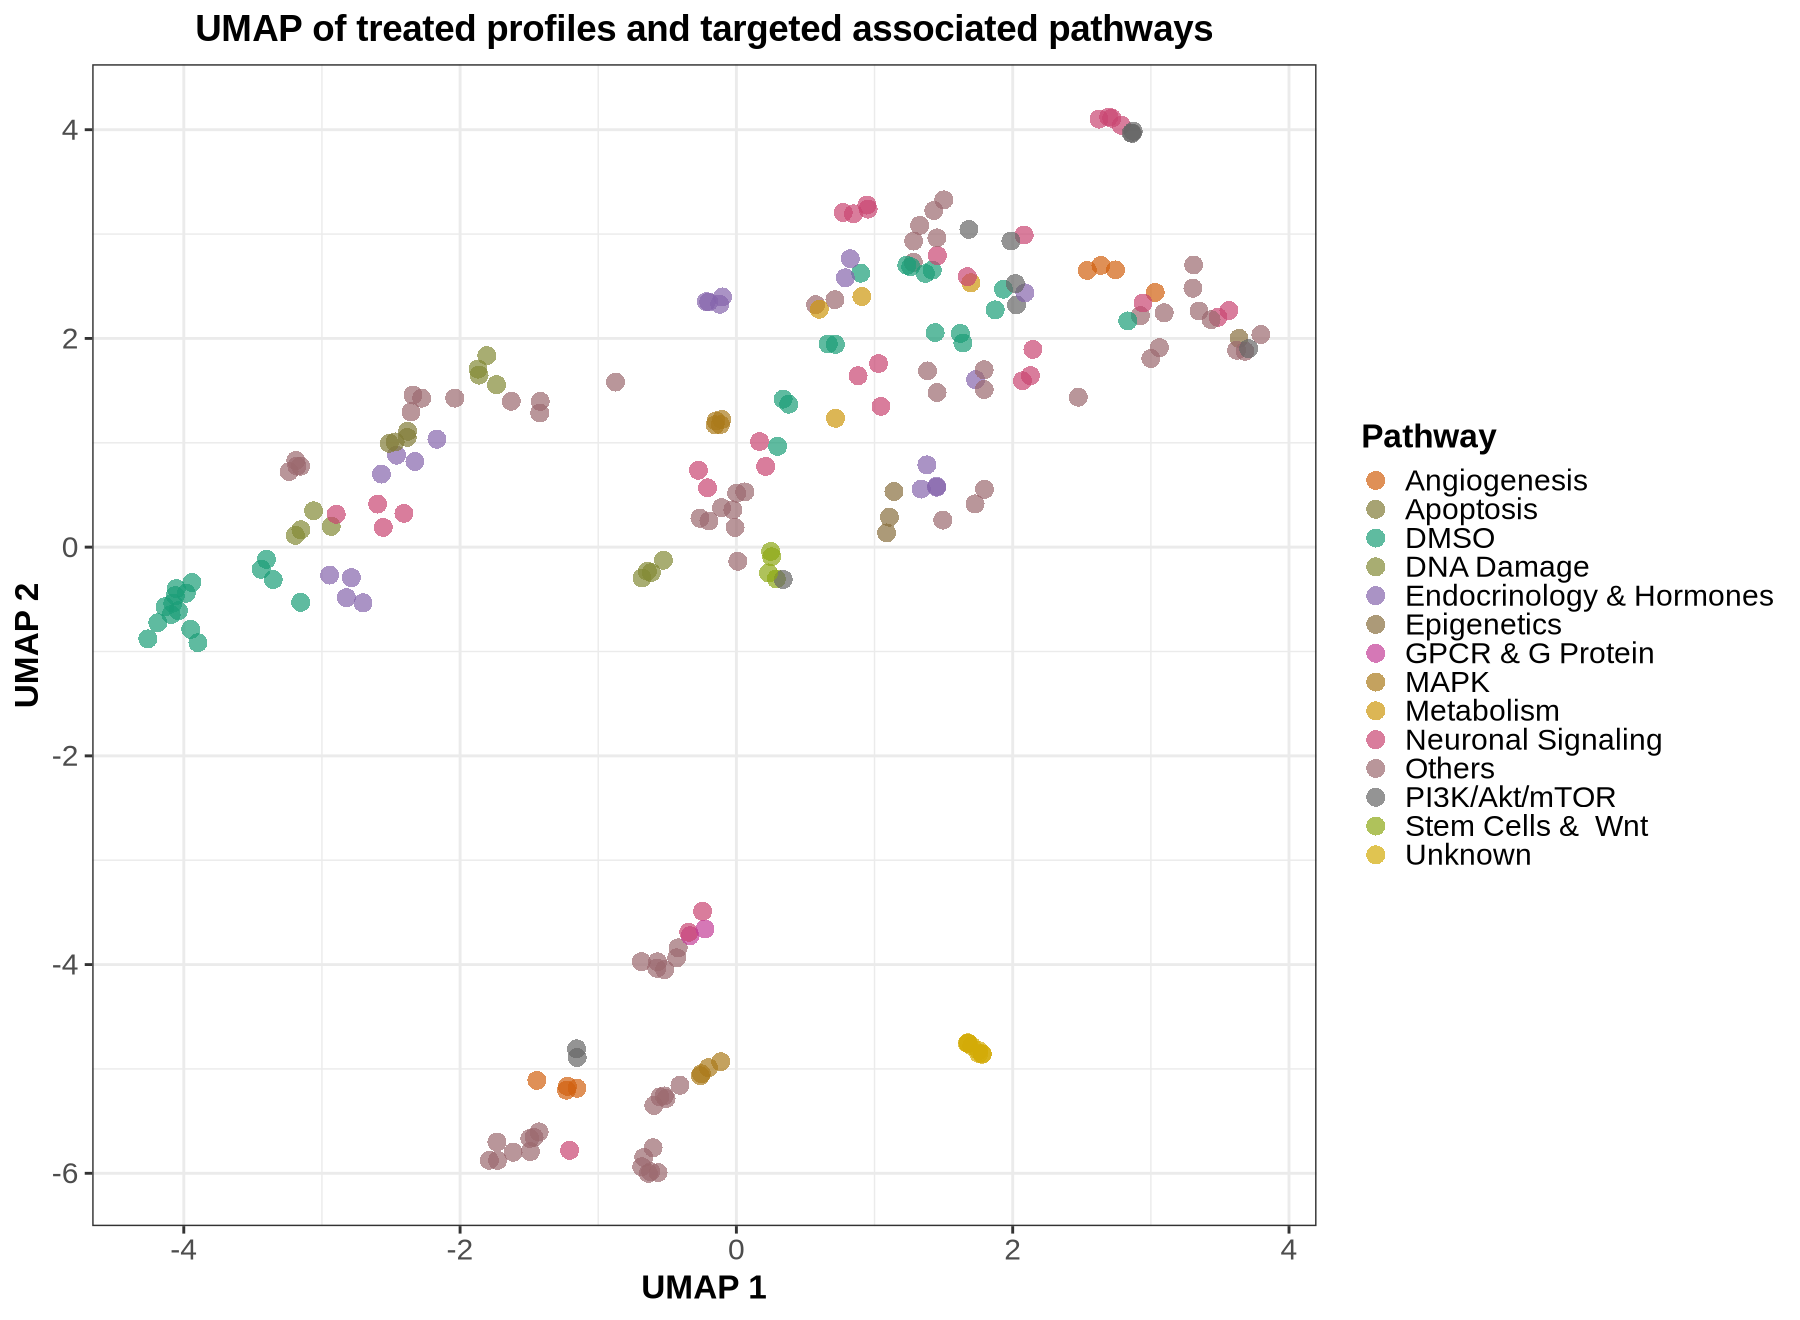

In [10]:

# Generate a color palette dynamically for unique pathways (colorblind-friendly)
pathway_colors <- setNames(
  colorRampPalette(brewer.pal(8, "Dark2"))(length(unique(umap_df$Pathway))),  
  unique(umap_df$Pathway)
)

# Plotting UMAP coloring based on the Pathway
ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Pathway)) +
  geom_point(alpha = 0.7, size = 5, shape = 16) +  
  scale_color_manual(values = pathway_colors) +  
  theme_bw( base_size = 18) +  
  labs(
    title = "UMAP of treated profiles and targeted associated pathways",
    x = "UMAP 1",
    y = "UMAP 2",
    color = "Pathway"
  ) +
  theme(
    legend.position = "right",  
    legend.text = element_text(size = 18),  
    legend.title = element_text(size = 20, face = "bold"),  
    axis.text = element_text(size = 18),  
    axis.title = element_text(size = 20, face = "bold"), 
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5)  
  )

# save figure into the output folder
path.figure <- file.path(path.output, "umap_pathway_profiles.png")
ggsave(path.figure, width = 15, height = 11, units = "in", dpi = 300)
print(paste("UMAP of pathway profiles saved at", path.figure))


> This facet plot presents UMAP embeddings generated at the batch level, encompassing four plates, with data points colored according to their respective pathways.

## UMAP plates vs pathway facet

[1] "UMAP of all plate and pathway profiles saved at ./results/umap/facetplot_umap_all_plate_pathway_profiles.png"


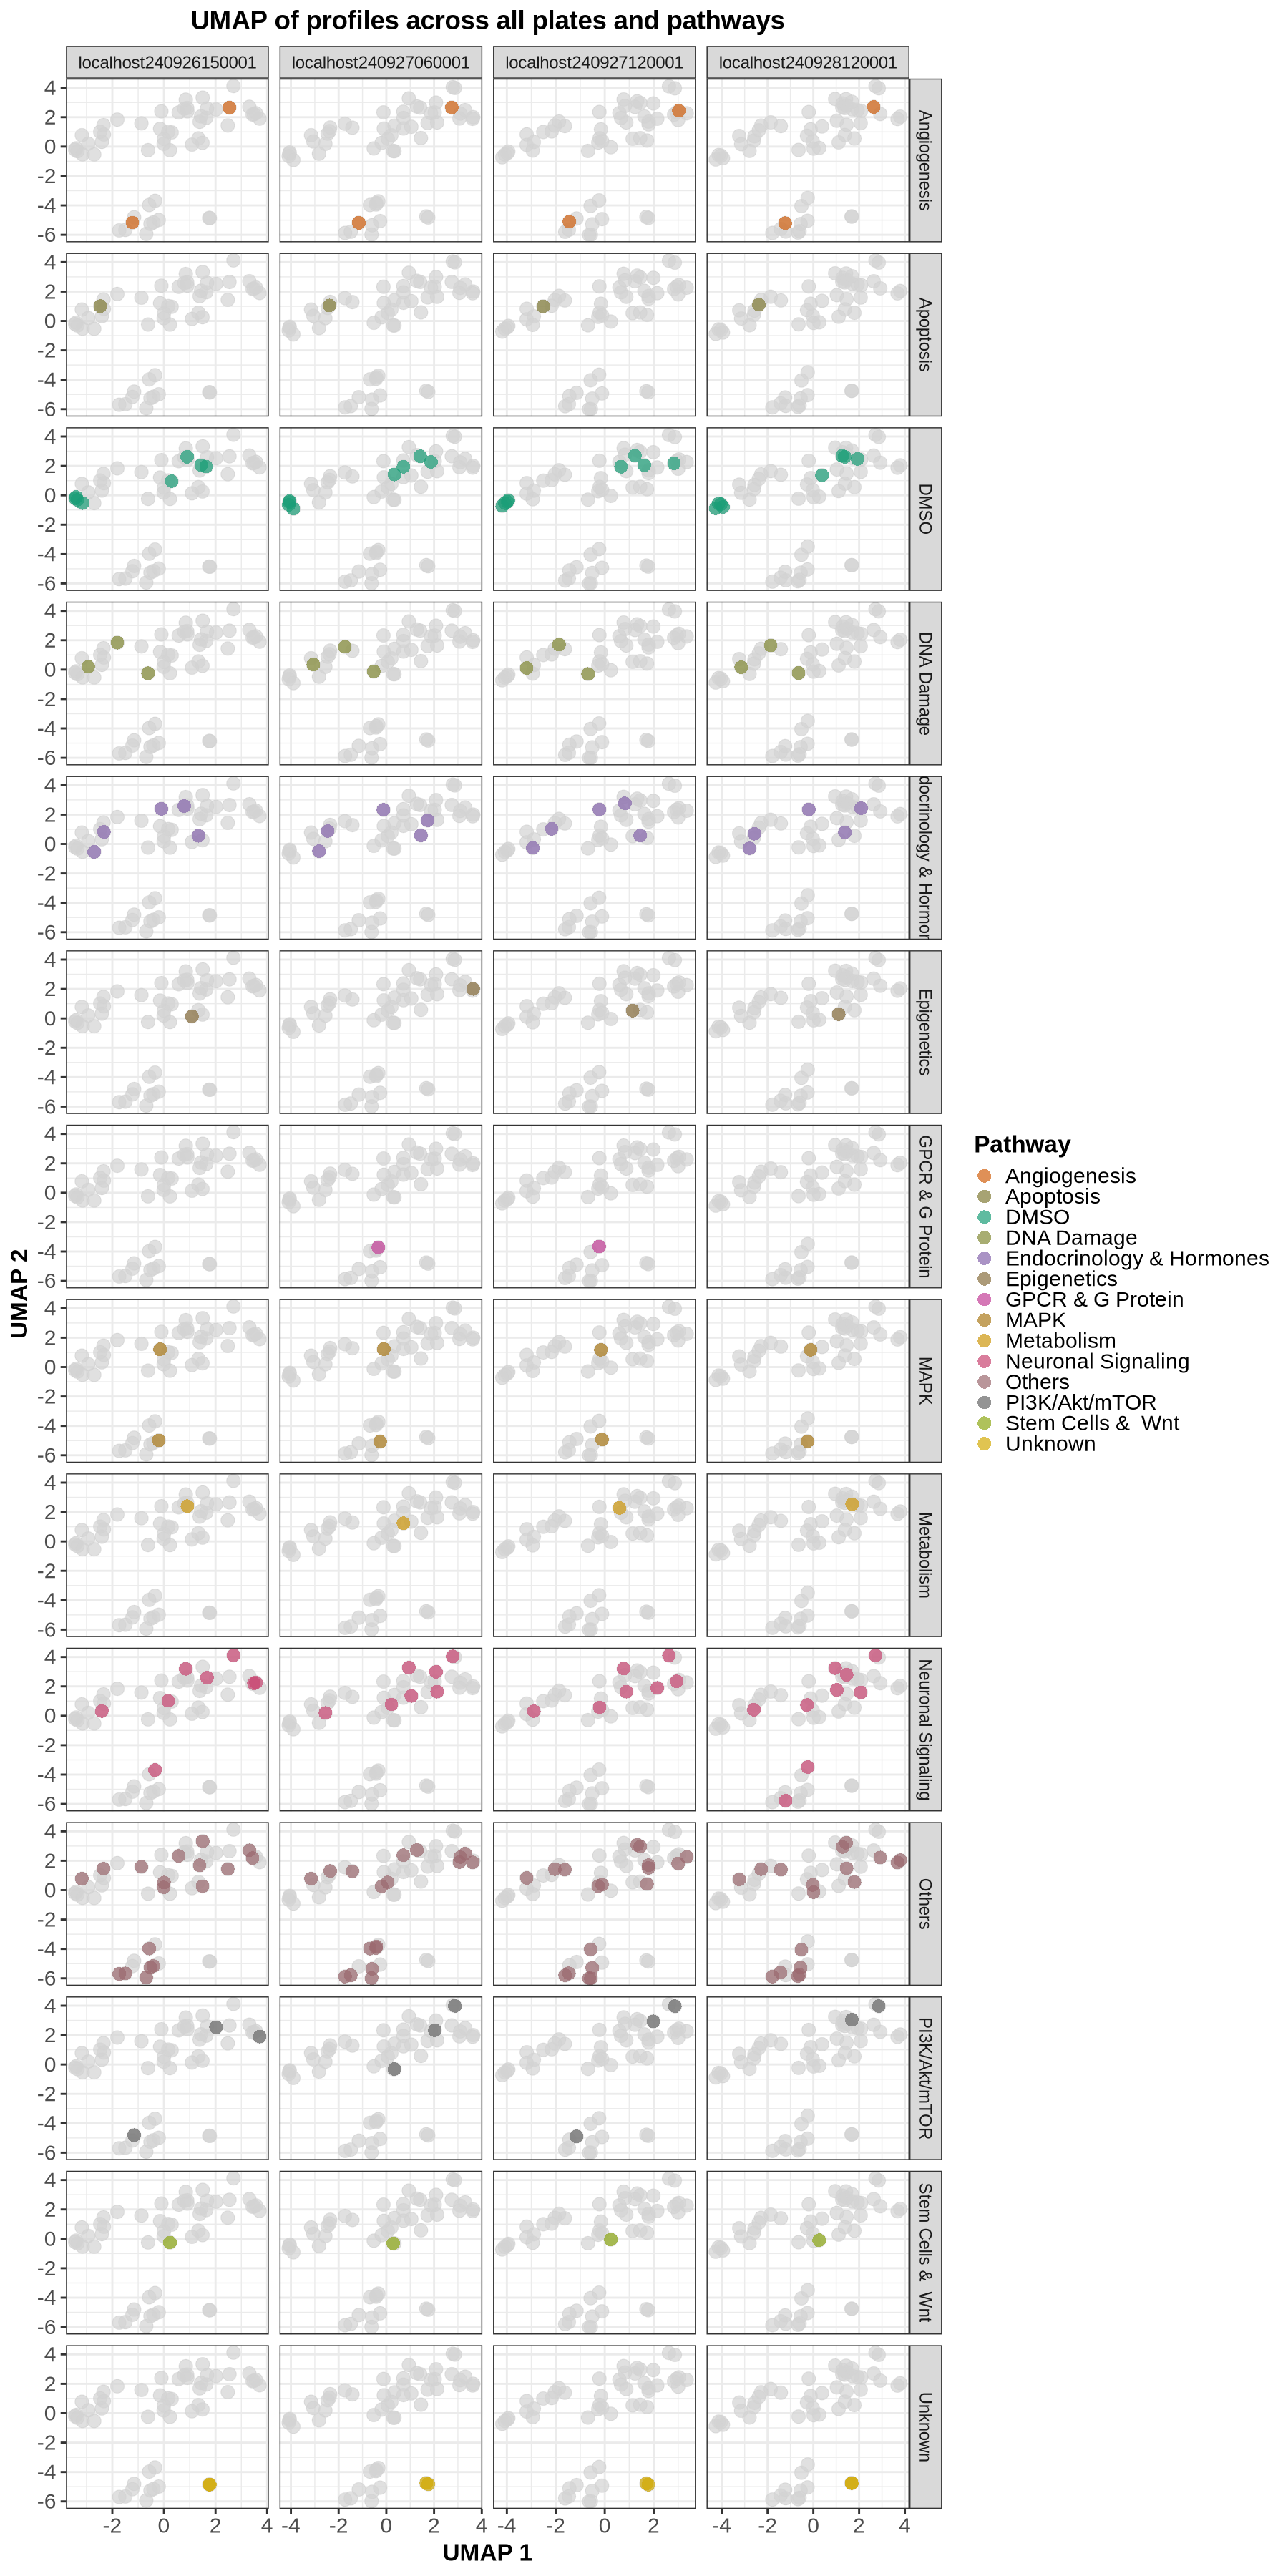

In [11]:
# update figure size
options(repr.plot.width = 15, repr.plot.height = 30)

# using the same UMAP coordinates, create a new dataframe as "background_df" in order to plot the background
background_df <- data.frame(
  Plate = umap_df$Plate,
  UMAP1 = umap_df$UMAP1,
  UMAP2 = umap_df$UMAP2
)

# create a facet grid plot where the rows represent Plate and the columns represent Pathway
ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Pathway)) +

  # generate a background plot in light gray
  geom_point(data = background_df, aes(x = UMAP1, y = UMAP2), color = "lightgray", alpha = 0.7, size = 5) +

  # generate forground plot with color based on Pathway
  geom_point(alpha = 0.7, size = 5, shape = 16) +
  scale_color_manual(values = pathway_colors) +
  theme_bw(base_size = 18) +
  labs(
    title = "UMAP of profiles across all plates and pathways",
    x = "UMAP 1",
    y = "UMAP 2",
    color = "Pathway"
  ) +
  facet_grid(Pathway ~ Plate, scales = "free") +
  theme(
    legend.position = "right",
    legend.text = element_text(size = 18),
    legend.title = element_text(size = 20, face = "bold"),
    axis.text = element_text(size = 18),
    axis.title = element_text(size = 20, face = "bold"),
    plot.title = element_text(size = 22, face = "bold", hjust = 0.5)
  )

# save plot
path.figure <- file.path(path.output, "facetplot_umap_all_plate_pathway_profiles.png")
ggsave(path.figure, width = 15, height = 30, units = "in", dpi = 300)
print(paste("UMAP of all plate and pathway profiles saved at", path.figure))


> This facet plot displays UMAP embeddings across two facets: the plate within the batch and all compound pathways. Colored points represent compounds associated with specific pathways.

In [12]:
# filter this to only where Pathwat is DMSO
umap_df_dmsos <- umap_df[umap_df$Pathway == "DMSO", ]

umap_df_dmsos

,Plate,Pathway,Treatment,UMAP1,UMAP2
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,localhost240927060001,DMSO,DMSO-positive,-4.0617546,-0.4648168
4,localhost240927060001,DMSO,DMSO-positive,-4.0534998,-0.3969046
7,localhost240927060001,DMSO,DMSO-positive,-4.0915969,-0.6467976
10,localhost240927060001,DMSO,DMSO-positive,-3.8974832,-0.9155936
27,localhost240927060001,DMSO,DMSO-negative,0.3383551,1.4185398
30,localhost240927060001,DMSO,DMSO-negative,0.7167686,1.9429084
33,localhost240927060001,DMSO,DMSO-negative,1.4174877,2.6542768
36,localhost240927060001,DMSO,DMSO-negative,1.8732247,2.2737262
56,localhost240928120001,DMSO,DMSO-positive,-4.1360558,-0.5713960
